### 1.	A full report consisting of all of the following components (15 marks):

#### Introduction where you discuss the business problem and who would be interested in this project.

I was having a conversation with a real estate agent and he asked if we could use data science to serve his client better. Hence, I've picked this as my final project

#### Data where you describe the data that will be used to solve the problem and the source of the data.

the data is provided by the government at data.gov.sg it show a list of details on the transaction of Singapore’s Public Housing (aka HDB)

#### Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

I first clean the report extensively and geo tagged the houses it with another excel file.

Subsequently, we will look at the average selling price of the house at various towns, using psf (per square feet) as a normalised data.

I will add the distance from key areas of Singapore to see if there is any correlation.

We will then use graph to show the various flat type and their average price across different town.

lastly, we will build a simple prediciton model to see if the house was sold at a "correct" price based on comparison with average prices across the same town

#### Results section where you discuss the results.

the results and steps are shown below:

Import the Libraries

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
from pathlib import Path
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric
from math import radians
import matplotlib.ticker as ticker
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import itertools

mpl.style.use('ggplot') # optional: for ggplot-like style

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


Retrive SG Resale Market Excel File

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/michaelliao65/Coursera_Capstone/main/SG%20Resale%20Flat%20Price.csv")
df.head()

,month,Date,town,flat_type,block,street_name,street_name_combine,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,remaining_lease_months,remaining_lease_years,resale_price,distance_to_CBD
0,2020/06,1 Jun 2020,WOODLANDS,5 ROOM,216,MARSILING LANE,216 MARSILING LANE,16 TO 18,118.0,Improved,1981.0,59 years 10 months,718.0,59.833333,370000.0,#REF!
1,2020/06,1 Jun 2020,WOODLANDS,4 ROOM,217,MARSILING CRES,217 MARSILING CRES,10 TO 12,104.0,Model A,1982.0,61 years 06 months,738.0,61.500000,310000.0,#REF!
2,2020/06,1 Jun 2020,WOODLANDS,3 ROOM,217,MARSILING CRES,217 MARSILING CRES,04 TO 06,74.0,Model A,1982.0,61 years 05 months,737.0,61.416667,218000.0,#REF!
3,2020/06,1 Jun 2020,JURONG WEST,EXECUTIVE,906,JURONG WEST ST 91,906 JURONG WEST ST 91,04 TO 06,145.0,Maisonette,1989.0,67 years 08 months,812.0,67.666667,535000.0,#REF!
4,2020/06,1 Jun 2020,WOODLANDS,3 ROOM,206,MARSILING DR,206 MARSILING DR,10 TO 12,68.0,New Generation,1981.0,59 years 11 months,719.0,59.916667,225000.0,#REF!


Drop some columns

In [3]:
df.drop(columns=['block', 'street_name','distance_to_CBD'], axis=1, inplace=True)
df.head()

,month,Date,town,flat_type,street_name_combine,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,remaining_lease_months,remaining_lease_years,resale_price
0,2020/06,1 Jun 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,16 TO 18,118.0,Improved,1981.0,59 years 10 months,718.0,59.833333,370000.0
1,2020/06,1 Jun 2020,WOODLANDS,4 ROOM,217 MARSILING CRES,10 TO 12,104.0,Model A,1982.0,61 years 06 months,738.0,61.500000,310000.0
2,2020/06,1 Jun 2020,WOODLANDS,3 ROOM,217 MARSILING CRES,04 TO 06,74.0,Model A,1982.0,61 years 05 months,737.0,61.416667,218000.0
3,2020/06,1 Jun 2020,JURONG WEST,EXECUTIVE,906 JURONG WEST ST 91,04 TO 06,145.0,Maisonette,1989.0,67 years 08 months,812.0,67.666667,535000.0
4,2020/06,1 Jun 2020,WOODLANDS,3 ROOM,206 MARSILING DR,10 TO 12,68.0,New Generation,1981.0,59 years 11 months,719.0,59.916667,225000.0


import lat long data

In [4]:
latlongdata = pd.read_csv("https://raw.githubusercontent.com/michaelliao65/Coursera_Capstone/main/Lat%20long%20of%20sg%20add.csv")
latlongdata.head()

,block,street_name,street_name_combine,latitude,longitude
0,353A,ADMIRALTY DR,353A ADMIRALTY DR,1.450675,103.818946
1,353B,ADMIRALTY DR,353B ADMIRALTY DR,1.450047,103.819231
2,353C,ADMIRALTY DR,353C ADMIRALTY DR,1.449724,103.819317
3,354A,ADMIRALTY DR,354A ADMIRALTY DR,1.450112,103.818841
4,354B,ADMIRALTY DR,354B ADMIRALTY DR,1.450401,103.818588


drop some columns

In [5]:
latlongdata.drop(columns=['block', 'street_name'], axis=1, inplace=True)
latlongdata.head()

,street_name_combine,latitude,longitude
0,353A ADMIRALTY DR,1.450675,103.818946
1,353B ADMIRALTY DR,1.450047,103.819231
2,353C ADMIRALTY DR,1.449724,103.819317
3,354A ADMIRALTY DR,1.450112,103.818841
4,354B ADMIRALTY DR,1.450401,103.818588


Merge both files

In [6]:
ddf = pd.merge(df,latlongdata, on = 'street_name_combine')
ddf.head()

,month,Date,town,flat_type,street_name_combine,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,remaining_lease_months,remaining_lease_years,resale_price,latitude,longitude
0,2020/06,1 Jun 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,16 TO 18,118.0,Improved,1981.0,59 years 10 months,718.0,59.833333,370000.0,1.447116,103.772179
1,2020/02,1 Feb 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,04 TO 06,118.0,Improved,1981.0,60 years 01 month,721.0,60.083333,337000.0,1.447116,103.772179
2,2019/11,1 Nov 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,10 TO 12,118.0,Improved,1981.0,60 years 04 months,724.0,60.333333,360000.0,1.447116,103.772179
3,2019/08,1 Aug 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,13 TO 15,118.0,Improved,1981.0,60 years 06 months,726.0,60.500000,365000.0,1.447116,103.772179
4,2020/06,1 Jun 2020,WOODLANDS,4 ROOM,217 MARSILING CRES,10 TO 12,104.0,Model A,1982.0,61 years 06 months,738.0,61.500000,310000.0,1.446794,103.772666


Compute per square foot price

In [7]:
ddf["psf"] = ddf["resale_price"] / ddf["floor_area_sqm"]
ddf.head()

,month,Date,town,flat_type,street_name_combine,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,remaining_lease_months,remaining_lease_years,resale_price,latitude,longitude,psf
0,2020/06,1 Jun 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,16 TO 18,118.0,Improved,1981.0,59 years 10 months,718.0,59.833333,370000.0,1.447116,103.772179,3135.593220
1,2020/02,1 Feb 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,04 TO 06,118.0,Improved,1981.0,60 years 01 month,721.0,60.083333,337000.0,1.447116,103.772179,2855.932203
2,2019/11,1 Nov 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,10 TO 12,118.0,Improved,1981.0,60 years 04 months,724.0,60.333333,360000.0,1.447116,103.772179,3050.847458
3,2019/08,1 Aug 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,13 TO 15,118.0,Improved,1981.0,60 years 06 months,726.0,60.500000,365000.0,1.447116,103.772179,3093.220339
4,2020/06,1 Jun 2020,WOODLANDS,4 ROOM,217 MARSILING CRES,10 TO 12,104.0,Model A,1982.0,61 years 06 months,738.0,61.500000,310000.0,1.446794,103.772666,2980.769231


drop nan values

In [8]:
ddf = ddf.dropna()

prepare foursquare credentials

In [9]:
CLIENT_ID = '1YE15MJLQUCAA1TRNOCB1LOH1TXARNJ3BIYKYPUGHE3GT0RJ' # your Foursquare ID
CLIENT_SECRET = '12BIBOBBS4RFP1GKIAIXHHRI2TLUY05Z3YMXWM4PRPNEVJRM' # your Foursquare Secret
ACCESS_TOKEN = 'ML0GU04T0AATFNL4BNDLXPJ00VMSW3IVTNQXMYKD2YGK2R5X' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1YE15MJLQUCAA1TRNOCB1LOH1TXARNJ3BIYKYPUGHE3GT0RJ
CLIENT_SECRET:12BIBOBBS4RFP1GKIAIXHHRI2TLUY05Z3YMXWM4PRPNEVJRM


search for key areas in SG, for this assignment, we will use three
1) Changi, SG's airport
2) Orchard Road, SG's shopping district
3) Raffles Place, SG's central business district

In [10]:
address = 'changi airport SINGAPORE'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
changilat = location.latitude
changilong = location.longitude
print(changilat, changilong)

1.35755735 103.98847034565972


In [11]:
address = 'orchard road SINGAPORE'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
ORlat = location.latitude
ORlong = location.longitude
print(ORlat, ORlong)

1.3003426 103.8419492


In [12]:
address = 'Raffles Place SINGAPORE'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
RPlat = location.latitude
RPlong = location.longitude
print(RPlat, RPlong)

1.2835416999999998 103.85146023266938


With the location lat long, we will calculate the distance from these areas to the house that was sold

In [13]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [14]:
distancesfromChangi = []
for row in ddf.itertuples(index=False):
   distancesfromChangi.append(
       haversine_distance(changilat, changilong, row.latitude, row.longitude)
   )
ddf['Distance from Changi'] = distancesfromChangi
ddf.head()

,month,Date,town,flat_type,street_name_combine,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,remaining_lease_months,remaining_lease_years,resale_price,latitude,longitude,psf,Distance from Changi
0,2020/06,1 Jun 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,16 TO 18,118.0,Improved,1981.0,59 years 10 months,718.0,59.833333,370000.0,1.447116,103.772179,3135.593220,26.02
1,2020/02,1 Feb 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,04 TO 06,118.0,Improved,1981.0,60 years 01 month,721.0,60.083333,337000.0,1.447116,103.772179,2855.932203,26.02
2,2019/11,1 Nov 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,10 TO 12,118.0,Improved,1981.0,60 years 04 months,724.0,60.333333,360000.0,1.447116,103.772179,3050.847458,26.02
3,2019/08,1 Aug 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,13 TO 15,118.0,Improved,1981.0,60 years 06 months,726.0,60.500000,365000.0,1.447116,103.772179,3093.220339,26.02
4,2020/06,1 Jun 2020,WOODLANDS,4 ROOM,217 MARSILING CRES,10 TO 12,104.0,Model A,1982.0,61 years 06 months,738.0,61.500000,310000.0,1.446794,103.772666,2980.769231,25.96


In [15]:
distancesfromOR = []
for row in ddf.itertuples(index=False):
   distancesfromOR.append(
       haversine_distance(ORlat, ORlong, row.latitude, row.longitude)
   )
ddf['Distance from Orchard'] = distancesfromOR

distancesfromRP = []
for row in ddf.itertuples(index=False):
   distancesfromRP.append(
       haversine_distance(RPlat, RPlong, row.latitude, row.longitude)
   )
ddf['Distance from Raffles Place'] = distancesfromRP
ddf.head()

,month,Date,town,flat_type,street_name_combine,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,remaining_lease_months,remaining_lease_years,resale_price,latitude,longitude,psf,Distance from Changi,Distance from Orchard,Distance from Raffles Place
0,2020/06,1 Jun 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,16 TO 18,118.0,Improved,1981.0,59 years 10 months,718.0,59.833333,370000.0,1.447116,103.772179,3135.593220,26.02,18.07,20.21
1,2020/02,1 Feb 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,04 TO 06,118.0,Improved,1981.0,60 years 01 month,721.0,60.083333,337000.0,1.447116,103.772179,2855.932203,26.02,18.07,20.21
2,2019/11,1 Nov 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,10 TO 12,118.0,Improved,1981.0,60 years 04 months,724.0,60.333333,360000.0,1.447116,103.772179,3050.847458,26.02,18.07,20.21
3,2019/08,1 Aug 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,13 TO 15,118.0,Improved,1981.0,60 years 06 months,726.0,60.500000,365000.0,1.447116,103.772179,3093.220339,26.02,18.07,20.21
4,2020/06,1 Jun 2020,WOODLANDS,4 ROOM,217 MARSILING CRES,10 TO 12,104.0,Model A,1982.0,61 years 06 months,738.0,61.500000,310000.0,1.446794,103.772666,2980.769231,25.96,18.01,20.16


create psf average across different town

In [16]:
psfcompbytown = ddf.groupby("town")["psf"].mean().reset_index()
psfcompbytown.set_index('town', inplace=True)

In [17]:
ddf = pd.merge(ddf,psfcompbytown, on = 'town')
ddf.head()

,month,Date,town,flat_type,street_name_combine,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,remaining_lease_months,remaining_lease_years,resale_price,latitude,longitude,psf_x,Distance from Changi,Distance from Orchard,Distance from Raffles Place,psf_y
0,2020/06,1 Jun 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,16 TO 18,118.0,Improved,1981.0,59 years 10 months,718.0,59.833333,370000.0,1.447116,103.772179,3135.593220,26.02,18.07,20.21,3550.657899
1,2020/02,1 Feb 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,04 TO 06,118.0,Improved,1981.0,60 years 01 month,721.0,60.083333,337000.0,1.447116,103.772179,2855.932203,26.02,18.07,20.21,3550.657899
2,2019/11,1 Nov 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,10 TO 12,118.0,Improved,1981.0,60 years 04 months,724.0,60.333333,360000.0,1.447116,103.772179,3050.847458,26.02,18.07,20.21,3550.657899
3,2019/08,1 Aug 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,13 TO 15,118.0,Improved,1981.0,60 years 06 months,726.0,60.500000,365000.0,1.447116,103.772179,3093.220339,26.02,18.07,20.21,3550.657899
4,2020/06,1 Jun 2020,WOODLANDS,4 ROOM,217 MARSILING CRES,10 TO 12,104.0,Model A,1982.0,61 years 06 months,738.0,61.500000,310000.0,1.446794,103.772666,2980.769231,25.96,18.01,20.16,3550.657899


In [18]:
ddf.rename(columns={'psf_x': 'psf'}, inplace=True)
ddf.rename(columns={'psf_y': 'psf of town'}, inplace=True)
ddf.head()

,month,Date,town,flat_type,street_name_combine,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,remaining_lease_months,remaining_lease_years,resale_price,latitude,longitude,psf,Distance from Changi,Distance from Orchard,Distance from Raffles Place,psf of town
0,2020/06,1 Jun 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,16 TO 18,118.0,Improved,1981.0,59 years 10 months,718.0,59.833333,370000.0,1.447116,103.772179,3135.593220,26.02,18.07,20.21,3550.657899
1,2020/02,1 Feb 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,04 TO 06,118.0,Improved,1981.0,60 years 01 month,721.0,60.083333,337000.0,1.447116,103.772179,2855.932203,26.02,18.07,20.21,3550.657899
2,2019/11,1 Nov 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,10 TO 12,118.0,Improved,1981.0,60 years 04 months,724.0,60.333333,360000.0,1.447116,103.772179,3050.847458,26.02,18.07,20.21,3550.657899
3,2019/08,1 Aug 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,13 TO 15,118.0,Improved,1981.0,60 years 06 months,726.0,60.500000,365000.0,1.447116,103.772179,3093.220339,26.02,18.07,20.21,3550.657899
4,2020/06,1 Jun 2020,WOODLANDS,4 ROOM,217 MARSILING CRES,10 TO 12,104.0,Model A,1982.0,61 years 06 months,738.0,61.500000,310000.0,1.446794,103.772666,2980.769231,25.96,18.01,20.16,3550.657899


In [19]:
ddf["seller price fair?"] = ddf["psf"] > ddf["psf of town"]
ddf.head()

,month,Date,town,flat_type,street_name_combine,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,remaining_lease_years,resale_price,latitude,longitude,psf,Distance from Changi,Distance from Orchard,Distance from Raffles Place,psf of town,seller price fair?
0,2020/06,1 Jun 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,16 TO 18,118.0,Improved,1981.0,59 years 10 months,...,59.833333,370000.0,1.447116,103.772179,3135.593220,26.02,18.07,20.21,3550.657899,False
1,2020/02,1 Feb 2020,WOODLANDS,5 ROOM,216 MARSILING LANE,04 TO 06,118.0,Improved,1981.0,60 years 01 month,...,60.083333,337000.0,1.447116,103.772179,2855.932203,26.02,18.07,20.21,3550.657899,False
2,2019/11,1 Nov 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,10 TO 12,118.0,Improved,1981.0,60 years 04 months,...,60.333333,360000.0,1.447116,103.772179,3050.847458,26.02,18.07,20.21,3550.657899,False
3,2019/08,1 Aug 2019,WOODLANDS,5 ROOM,216 MARSILING LANE,13 TO 15,118.0,Improved,1981.0,60 years 06 months,...,60.500000,365000.0,1.447116,103.772179,3093.220339,26.02,18.07,20.21,3550.657899,False
4,2020/06,1 Jun 2020,WOODLANDS,4 ROOM,217 MARSILING CRES,10 TO 12,104.0,Model A,1982.0,61 years 06 months,...,61.500000,310000.0,1.446794,103.772666,2980.769231,25.96,18.01,20.16,3550.657899,False


Generate graph of flats based on different town

In [20]:
twor = ddf.drop(ddf[ddf.flat_type != '2 ROOM'].index)
threer = ddf.drop(ddf[ddf.flat_type != '3 ROOM'].index)
fourr = ddf.drop(ddf[ddf.flat_type != '4 ROOM'].index)
fiver = ddf.drop(ddf[ddf.flat_type != '5 ROOM'].index)
exer = ddf.drop(ddf[ddf.flat_type != 'EXECUTIVE'].index)
mulgenr = ddf.drop(ddf[ddf.flat_type != 'MULTI-GENERATION'].index)

In [21]:
tworcomp = twor.groupby("town")["resale_price"].mean().reset_index()
tworcomp.set_index('town', inplace=True)
tworcomp.rename(columns={"resale_price": "2room_resale_price"}, inplace=True)


threercomp = threer.groupby("town")["resale_price"].mean().reset_index()
threercomp.set_index('town', inplace=True)
threercomp.rename(columns={"resale_price": "3room_resale_price"}, inplace=True)

fourrcomp = fourr.groupby("town")["resale_price"].mean().reset_index()
fourrcomp.set_index('town', inplace=True)
fourrcomp.rename(columns={"resale_price": "4room_resale_price"}, inplace=True)

fivercomp = fiver.groupby("town")["resale_price"].mean().reset_index()
fivercomp.set_index('town', inplace=True)
fivercomp.rename(columns={"resale_price": "5room_resale_price"}, inplace=True)

exercomp = exer.groupby("town")["resale_price"].mean().reset_index()
exercomp.set_index('town', inplace=True)
exercomp.rename(columns={"resale_price": "executive_resale_price"}, inplace=True)

mulgenrcomp = mulgenr.groupby("town")["resale_price"].mean().reset_index()
mulgenrcomp.set_index('town', inplace=True)
mulgenrcomp.rename(columns={"resale_price": "multigen_resale_price"}, inplace=True)

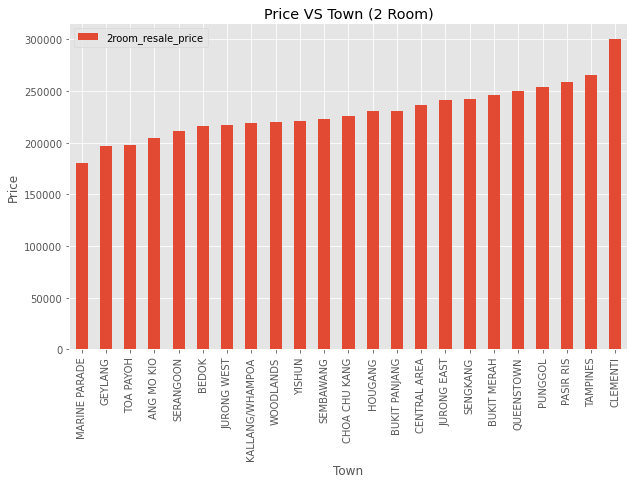

In [22]:
tworcompsorted=tworcomp.sort_values(by=["2room_resale_price"])

tworcompsorted.plot(kind='bar', figsize=(10, 6), rot=90) 

plt.xlabel('Town')
plt.ylabel('Price')
plt.title('Price VS Town (2 Room)')

plt.show()

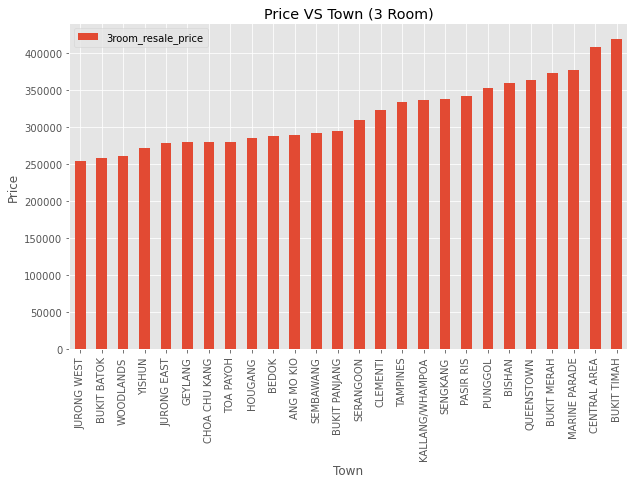

In [23]:
threercompsorted=threercomp.sort_values(by=['3room_resale_price'])

threercompsorted.plot(kind='bar', figsize=(10, 6), rot=90) 

plt.xlabel('Town')
plt.ylabel('Price')
plt.title('Price VS Town (3 Room)')

plt.show()

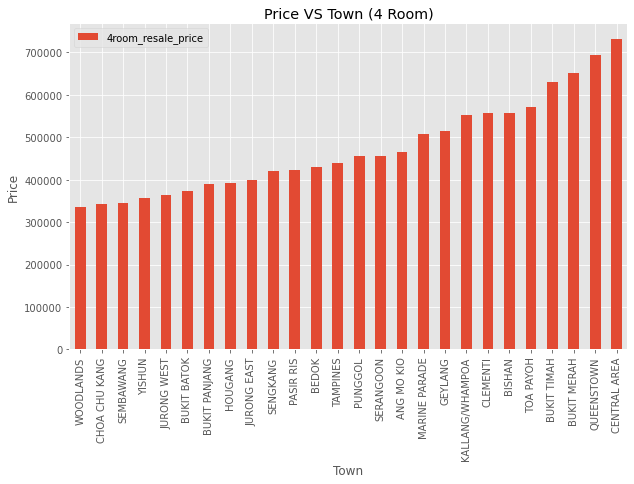

In [24]:
fourrcompsorted=fourrcomp.sort_values(by=['4room_resale_price'])

fourrcompsorted.plot(kind='bar', figsize=(10, 6), rot=90)

plt.xlabel('Town')
plt.ylabel('Price')
plt.title('Price VS Town (4 Room)')

plt.show()

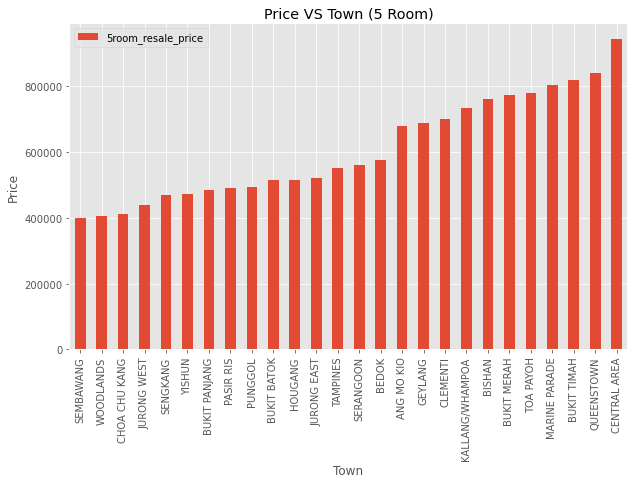

In [25]:
fivercompsorted=fivercomp.sort_values(by=['5room_resale_price'])

fivercompsorted.plot(kind='bar', figsize=(10, 6), rot=90) 

plt.xlabel('Town')
plt.ylabel('Price')
plt.title('Price VS Town (5 Room)')

plt.show()

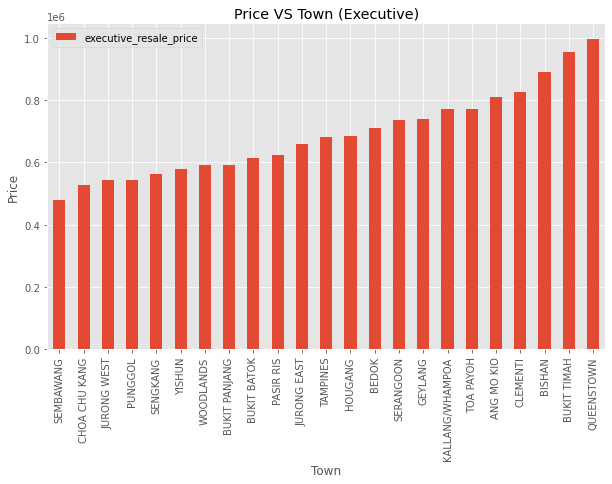

In [26]:
exercompsorted=exercomp.sort_values(by=['executive_resale_price'])

exercompsorted.plot(kind='bar', figsize=(10, 6), rot=90) 

plt.xlabel('Town')
plt.ylabel('Price')
plt.title('Price VS Town (Executive)')

plt.show()

compaing based on psf

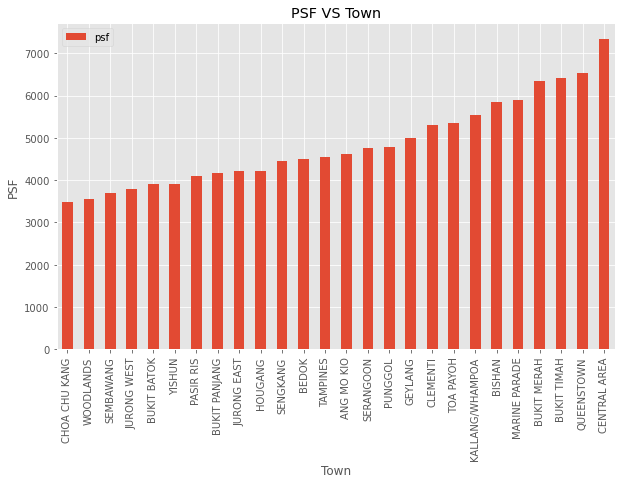

In [27]:
psfcompbytownsorted=psfcompbytown.sort_values(by=['psf'])

psfcompbytownsorted.plot(kind='bar', figsize=(10, 6), rot=90)

plt.xlabel('Town')
plt.ylabel('PSF')
plt.title('PSF VS Town')

plt.show()

In [28]:
psfcompbyflattype = ddf.groupby("flat_type")["psf"].mean().reset_index()
psfcompbyflattype.set_index('flat_type', inplace=True)

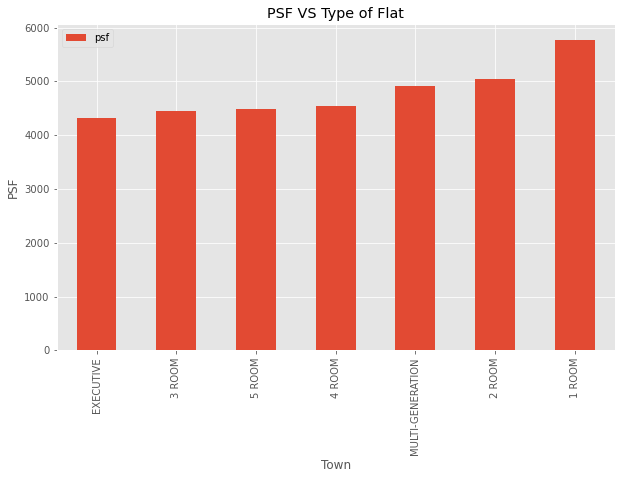

In [29]:
psfcompbyflattypesorted=psfcompbyflattype.sort_values(by=['psf'])

psfcompbyflattypesorted.plot(kind='bar', figsize=(10, 6), rot=90) # rotate the bars by 90 degrees

plt.xlabel('Town')
plt.ylabel('PSF')
plt.title('PSF VS Type of Flat')

plt.show()

create a simple predition model!

In [30]:
X = ddf[['floor_area_sqm','remaining_lease_months','resale_price','psf','Distance from Changi','Distance from Orchard','Distance from Raffles Place','psf of town']]

In [31]:
y = ddf['seller price fair?'].values

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (45198, 8) (45198,)
Test set: (11300, 8) (11300,)


In [33]:
# Modeling
from sklearn.neighbors import KNeighborsClassifier
k = 6
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [34]:
yhat = kNN_model.predict(X_test)
yhat[0:5]

array([False, False,  True, False,  True])

In [35]:
Ks=15
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    
    
    mean_acc[n-1]=np.mean(yhat==y_test);
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.96840708, 0.95646018, 0.95557522, 0.94929204, 0.94814159,
       0.94539823, 0.94539823, 0.93814159, 0.9379646 , 0.93415929,
       0.93433628, 0.93212389, 0.93079646, 0.9279646 ])

In [36]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

knn_yhat = kNN_model.predict(X_test)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(y_test, knn_yhat, average='weighted') )

KNN Jaccard index: 0.93
KNN F1-score: 0.93


In [37]:
ddf.corr()

,floor_area_sqm,lease_commence_date,remaining_lease_months,remaining_lease_years,resale_price,latitude,longitude,psf,Distance from Changi,Distance from Orchard,Distance from Raffles Place,psf of town,seller price fair?
floor_area_sqm,1.000000,0.166689,0.170570,0.170570,0.633254,0.163078,-0.020321,-0.090052,0.013744,0.242154,0.235272,-0.218588,0.047594
lease_commence_date,0.166689,1.000000,0.998156,0.998156,0.318838,0.361272,0.010022,0.294962,0.006722,0.308581,0.314752,-0.184931,0.472098
remaining_lease_months,0.170570,0.998156,1.000000,1.000000,0.321336,0.361080,0.009529,0.294574,0.007067,0.309817,0.315933,-0.185691,0.471945
remaining_lease_years,0.170570,0.998156,1.000000,1.000000,0.321336,0.361080,0.009529,0.294574,0.007067,0.309817,0.315933,-0.185691,0.471945
resale_price,0.633254,0.318838,0.321336,0.321336,1.000000,-0.258673,0.131989,0.697392,-0.136351,-0.299984,-0.311168,0.362666,0.455853
latitude,0.163078,0.361272,0.361080,0.361080,-0.258673,1.000000,-0.011657,-0.480737,0.050793,0.726100,0.771687,-0.705115,0.001871
longitude,-0.020321,0.010022,0.009529,0.009529,0.131989,-0.011657,1.000000,0.179332,-0.995482,-0.231438,-0.330642,0.269420,-0.039250
psf,-0.090052,0.294962,0.294574,0.294574,0.697392,-0.480737,0.179332,1.000000,-0.176864,-0.593877,-0.604610,0.669345,0.548720
Distance from Changi,0.013744,0.006722,0.007067,0.007067,-0.136351,0.050793,-0.995482,-0.176864,1.000000,0.247715,0.346288,-0.267942,0.043003
Distance from Orchard,0.242154,0.308581,0.309817,0.309817,-0.299984,0.726100,-0.231438,-0.593877,0.247715,1.000000,0.986707,-0.860892,-0.005758


#### Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.

the price based on various town are clearly shown in the tables. for instance, a 5-room flat will cost the most at central area, and the least at sembawang.

all in all, choa chu kang have the lowest average psf and central area have the highest witht he differences nearing two times.

we can see the correlation of the various data based on the correlationship table.

we have also included a prediction model which have a Jaccard/F1 score of 0.93, which is fairly accurate. 


#### Conclusion section where you conclude the report.

I've tried to use this final exercise to showcase the various tools that i've learned througout the entirie cosurse. i truly enjoy it. thank you!